In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the DUT-OMRON dataset and saliency maps
image_folder1 = r'C:\Users\SAI KEERTHAN\Downloads\DUT-OMRON-image\DUT-OMRON-image'
saliency_folder1 = r'C:\Users\SAI KEERTHAN\Downloads\DUT-OMRON-gt-pixelwise.zip\pixelwiseGT-new-PNG'

# Define the paths to the DUTS dataset and saliency maps
image_folder2 = r'C:\Users\SAI KEERTHAN\Downloads\DUTS-TE\DUTS-TE\DUTS-TE-Image'
saliency_folder2 = r'C:\Users\SAI KEERTHAN\Downloads\DUTS-TE\DUTS-TE\DUTS-TE-Mask'

image_paths1 = glob.glob(os.path.join(image_folder1, '*.jpg'))
saliency_paths1 = glob.glob(os.path.join(saliency_folder1, '*.png'))

image_paths2 = glob.glob(os.path.join(image_folder2, '*.jpg'))
saliency_paths2 = glob.glob(os.path.join(saliency_folder2, '*.png'))

print("Total DUT-OMRON dataset size for images:", len(image_paths1))
print("Total DUT-OMRON dataset size for saliency maps:", len(saliency_paths1))

print("Total ECSSD dataset size for images:", len(image_paths2))
print("Total ECSSD dataset size for saliency maps:", len(saliency_paths2))


Total DUT-OMRON dataset size for images: 5168
Total DUT-OMRON dataset size for saliency maps: 5168
Total ECSSD dataset size for images: 5019
Total ECSSD dataset size for saliency maps: 5019


In [2]:
train_images1, test_images1, train_saliency1, test_saliency1 = train_test_split(image_paths1, saliency_paths1, test_size=0.2, random_state=42)
train_images1, validation_images1, train_saliency1, validation_saliency1 = train_test_split(train_images1, train_saliency1, test_size=0.25, random_state=42)

train_images2, test_images2, train_saliency2, test_saliency2 = train_test_split(image_paths2, saliency_paths2, test_size=0.2, random_state=42)
train_images2, validation_images2, train_saliency2, validation_saliency2 = train_test_split(train_images2, train_saliency2, test_size=0.25, random_state=42)

train_images = train_images1
train_saliency = train_saliency1

validation_images = validation_images1
validation_saliency = validation_saliency1

test_images = test_images2
test_saliency = test_saliency2

print("DUT-OMRON Training set size:", len(train_images1))
print("DUT-OMRON Validation set size:", len(validation_images1))
print("DUT-OMRON Testing set size:", len(test_images1))

print("\nDUTS Training set size:", len(train_images2))
print("DUTS Validation set size:", len(validation_images2))
print("DUTS Testing set size:", len(test_images2))

print("\nOur model Training set size:", len(train_images))
print("Our model Validation set size:", len(validation_images))
print("Our model Testing set size:", len(test_images))



DUT-OMRON Training set size: 3100
DUT-OMRON Validation set size: 1034
DUT-OMRON Testing set size: 1034

DUTS Training set size: 3011
DUTS Validation set size: 1004
DUTS Testing set size: 1004

Our model Training set size: 3100
Our model Validation set size: 1034
Our model Testing set size: 1004


In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
    
def create_cnn_model():
    stream1= tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
    ])

    stream2 = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
    ])

    fusion = layers.Concatenate()([stream1.output, stream2.output])

    additional_layers = layers.Conv2D(1, (1, 1), activation='sigmoid')(fusion)
    additional_layers = tf.image.resize(additional_layers, (111, 111))   

    model = models.Model(inputs=[stream1.input, stream2.input], outputs=additional_layers)

    # Adding Learning Rate Schedule and Early Stopping
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compiling the model
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model, learning_rate_reduction, early_stopping


In [4]:
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0 
    return image

def preprocess_saliency(saliency_path):
    saliency = tf.keras.preprocessing.image.load_img(saliency_path, target_size=(111, 111), color_mode='grayscale')
    saliency = tf.keras.preprocessing.image.img_to_array(saliency)
    saliency = saliency / 255.0  
    return saliency


def load_data(image_paths, saliency_paths):
    
    images = []
    saliency_maps = []
    
    for image_path, saliency_path in zip(image_paths, saliency_paths):
        
        image = preprocess_image(image_path)
        saliency = preprocess_saliency(saliency_path)
        
        images.append(image)
        saliency_maps.append(saliency)
        
    images = np.array(images)
    saliency_maps = np.array(saliency_maps)
    
    return images, saliency_maps

In [5]:
train_images, train_saliency = load_data(train_images, train_saliency)

validation_images, validation_saliency = load_data(validation_images, validation_saliency)

test_images, test_saliency = load_data(test_images, test_saliency)

In [6]:
cnn_model, learning_rate_reduction, early_stopping = create_cnn_model()
epochs = 40
batch_size = 32

# Fitting the model with callbacks
history = cnn_model.fit([train_images, train_images], train_saliency, batch_size=batch_size, epochs=epochs,
                            validation_data=([validation_images, validation_images], validation_saliency),
                            callbacks=[learning_rate_reduction, early_stopping])


Epoch 1/40
97/97 [==============================] - 181s 2s/step - loss: 0.5449 - val_loss: 0.5098 - lr: 0.0100
Epoch 2/40
97/97 [==============================] - 169s 2s/step - loss: 0.4890 - val_loss: 0.4766 - lr: 0.0100
Epoch 3/40
97/97 [==============================] - 173s 2s/step - loss: 0.4624 - val_loss: 0.4562 - lr: 0.0100
Epoch 4/40
97/97 [==============================] - 168s 2s/step - loss: 0.4454 - val_loss: 0.4426 - lr: 0.0100
Epoch 5/40
97/97 [==============================] - 172s 2s/step - loss: 0.4344 - val_loss: 0.4338 - lr: 0.0100
Epoch 6/40
97/97 [==============================] - 170s 2s/step - loss: 0.4273 - val_loss: 0.4281 - lr: 0.0100
Epoch 7/40
97/97 [==============================] - 177s 2s/step - loss: 0.4225 - val_loss: 0.4244 - lr: 0.0100
Epoch 8/40
97/97 [==============================] - 182s 2s/step - loss: 0.4194 - val_loss: 0.4216 - lr: 0.0100
Epoch 9/40
97/97 [==============================] - 170s 2s/step - loss: 0.4171 - val_loss: 0.4200 - lr:

In [7]:
test_loss = cnn_model.evaluate([test_images, test_images], test_saliency)
print("Test loss:", test_loss)

predictions = cnn_model.predict([test_images, test_images])

def calculate_accuracy(y_true, y_pred):    
    
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)  
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binary.flatten()    

    accuracy = np.mean(np.equal(y_true_flat, y_pred_flat))
    return accuracy

test_accuracy = calculate_accuracy(test_saliency, predictions)
print("Test accuracy:", test_accuracy)


32/32 [==============================] - 15s 413ms/step - loss: 0.3974
Test loss: 0.3974485993385315
32/32 [==============================] - 18s 464ms/step
Test accuracy: 0.8507410985875506


In [34]:
def calculate_precision_recall_fmeasure(y_true, y_pred):
    # Flatten the ground truth and predicted saliency maps
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Threshold the predicted saliency map to convert it into binary format
    y_pred_binary = np.where(y_pred_flat >= 0.165, 1, 0)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = np.sum((y_true_flat == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_binary == 0))

    print("True Positives:", tp)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    
    # Calculate precision, recall, and F-measure
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f_measure = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return precision, recall, f_measure

precision, recall, f_measure = calculate_precision_recall_fmeasure(test_saliency, predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


True Positives: 864711
False Positives: 2849077
False Negatives: 809260
Precision: 0.23283800798537768
Recall: 0.516562712257261
F-measure: 0.3209909718850193


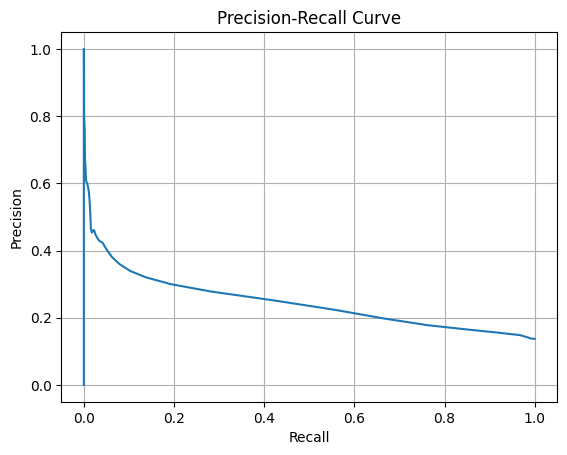

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'predictions' variable containing the predicted saliency map and the ground truth saliency maps

# Function to calculate precision and recall for a given threshold
def calculate_precision_recall(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(np.uint8)
    
    tp = np.sum((y_true == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    
    return precision, recall

# Assuming you have the 'test_saliency' variable containing the ground truth saliency maps
thresholds = np.linspace(0, 1, num=100)  # Generate 100 equally spaced thresholds from 0 to 1

precisions = []
recalls = []

for threshold in thresholds:
    precision, recall = calculate_precision_recall(test_saliency, predictions, threshold)
    precisions.append(precision)
    recalls.append(recall)

# Plot the precision-recall curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [36]:
cnn_model.save('40_32_0.01_DUT-OMRON_DUTS.h5')

In [37]:
# Function to save model weights
def save_model_weights(model, filename):
    model.save_weights(filename)

# Function to load model weights
def load_model_weights(model, filename):
    model.load_weights(filename)

# Save model weights after 20 epochs
save_model_weights(cnn_model, '40_32_0.01_DUT-OMRON_DUTS_after_40_epochs.h5')

# Now, let's say you want to resume training for 40 epochs:
epochs_to_resume = 60

# Load the saved model weights
load_model_weights(cnn_model, '40_32_0.01_DUT-OMRON_DUTS_after_40_epochs.h5')

history = cnn_model.fit(
    [train_images, train_images], train_saliency, batch_size=batch_size, epochs=epochs_to_resume - epochs,
    validation_data=([validation_images, validation_images], validation_saliency),
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/20
97/97 [==============================] - 170s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.9531e-05
Epoch 2/20
97/97 [==============================] - 167s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.9531e-05
Epoch 3/20
97/97 [==============================] - ETA: 0s - loss: 0.4101
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-05.
97/97 [==============================] - 168s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.9531e-05
Epoch 4/20
97/97 [==============================] - 163s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.0000e-05
Epoch 5/20
97/97 [==============================] - 170s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.0000e-05
Epoch 6/20
97/97 [==============================] - 171s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.0000e-05
Epoch 7/20
97/97 [==============================] - 165s 2s/step - loss: 0.4101 - val_loss: 0.4129 - lr: 1.0000e-05
Epoch 8/20
97/97 [==============================] - 166s 2s/step

In [38]:
test_loss = cnn_model.evaluate([test_images, test_images], test_saliency)
print("Test loss:", test_loss)

predictions = cnn_model.predict([test_images, test_images])

def calculate_accuracy(y_true, y_pred):    
    
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)  
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binary.flatten()    

    accuracy = np.mean(np.equal(y_true_flat, y_pred_flat))
    return accuracy

test_accuracy = calculate_accuracy(test_saliency, predictions)
print("Test accuracy:", test_accuracy)

32/32 [==============================] - 14s 404ms/step - loss: 0.3974
Test loss: 0.39743250608444214
32/32 [==============================] - 17s 496ms/step
Test accuracy: 0.8507411794264383


In [39]:
def calculate_precision_recall_fmeasure(y_true, y_pred):
    # Flatten the ground truth and predicted saliency maps
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Threshold the predicted saliency map to convert it into binary format
    y_pred_binary = np.where(y_pred_flat >= 0.165, 1, 0)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = np.sum((y_true_flat == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_binary == 0))

    print("True Positives:", tp)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    
    # Calculate precision, recall, and F-measure
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f_measure = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return precision, recall, f_measure

precision, recall, f_measure = calculate_precision_recall_fmeasure(test_saliency, predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


True Positives: 863204
False Positives: 2839775
False Negatives: 810767
Precision: 0.2331106927692541
Recall: 0.5156624577128275
F-measure: 0.32107570233949556


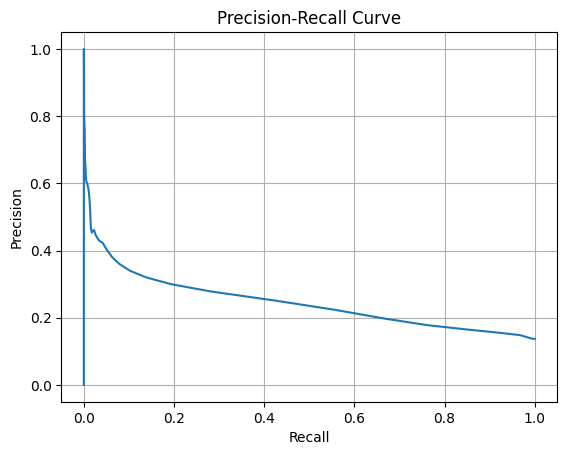

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'predictions' variable containing the predicted saliency map and the ground truth saliency maps

# Function to calculate precision and recall for a given threshold
def calculate_precision_recall(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(np.uint8)
    
    tp = np.sum((y_true == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    
    return precision, recall

# Assuming you have the 'test_saliency' variable containing the ground truth saliency maps
thresholds = np.linspace(0, 1, num=100)  # Generate 100 equally spaced thresholds from 0 to 1

precisions = []
recalls = []

for threshold in thresholds:
    precision, recall = calculate_precision_recall(test_saliency, predictions, threshold)
    precisions.append(precision)
    recalls.append(recall)

# Plot the precision-recall curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [41]:
save_model_weights(cnn_model, '60_32_0.01_DUT-OMRON_DUTS_after_60_epochs.h5')

cnn_model.save('60_32_0.01_DUT-OMRON_DUTS.h5')

1/1 [==============================] - 0s 44ms/step


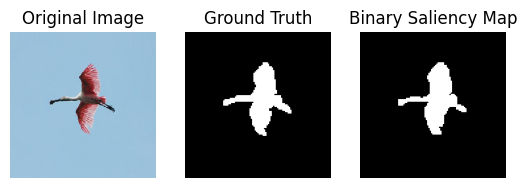

In [43]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000652.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00000652.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.14
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 37ms/step


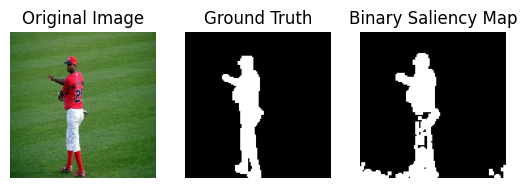

In [54]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00018970.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00018970.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.116
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 45ms/step


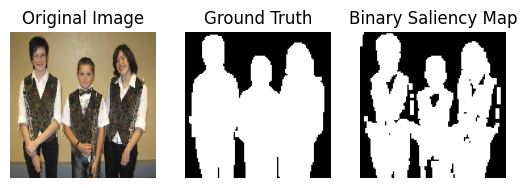

In [60]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00072735.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00072735.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.167
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 33ms/step


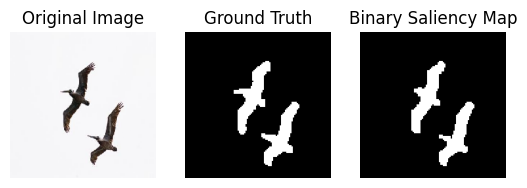

In [42]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000473.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00000473.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.16
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 39ms/step


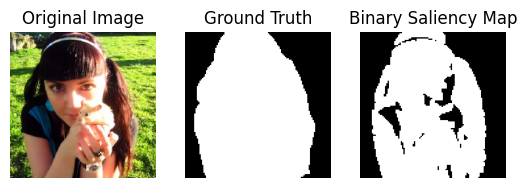

In [63]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00001360.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00001360.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.18
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 45ms/step


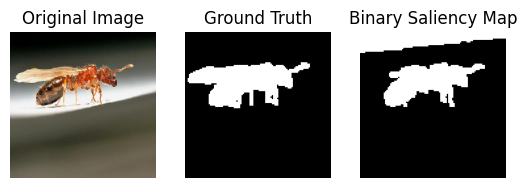

In [70]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000196.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00000196.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.17
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 50ms/step


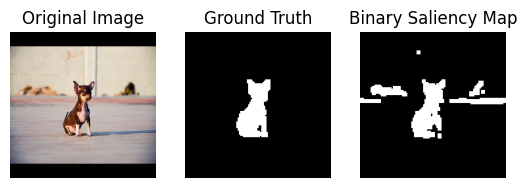

In [76]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000661.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00000661.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.19
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 38ms/step


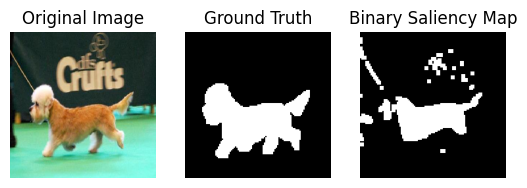

In [82]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000003.jpg")
ground_truth_saliency = preprocess_saliency(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Mask\ILSVRC2012_test_00000003.png") 

input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.18
threshold2 = 0.5
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)
binary_ground_truth = np.where(ground_truth_saliency >= threshold2, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

binary_ground_truth = np.squeeze(binary_ground_truth, axis=-1)  # Remove single-dimensional entry
binary_ground_truth = cv2.dilate(binary_ground_truth.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 40ms/step


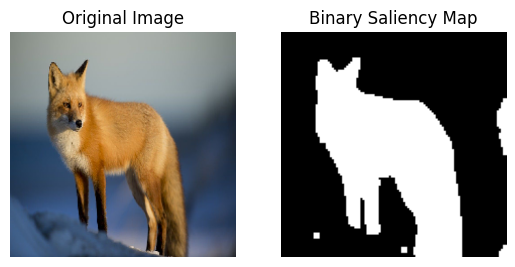

In [87]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Fox.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.155
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 38ms/step


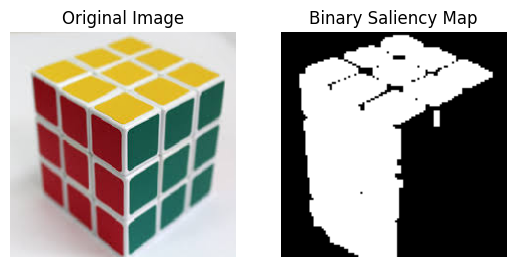

In [93]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\cube.jpeg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.14
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 41ms/step


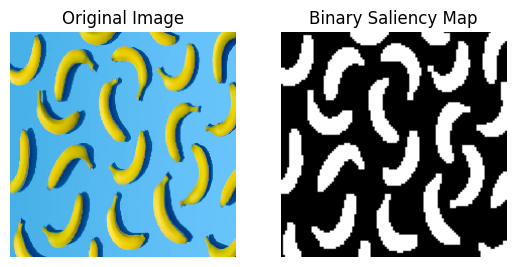

In [95]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\bananas.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.125
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 36ms/step


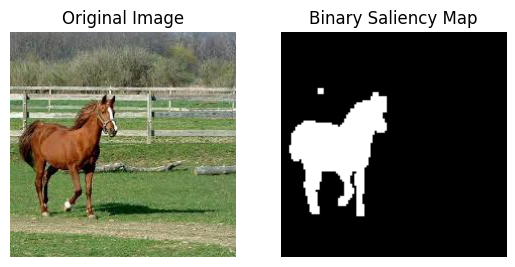

In [100]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\horse.jpeg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.19
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 43ms/step


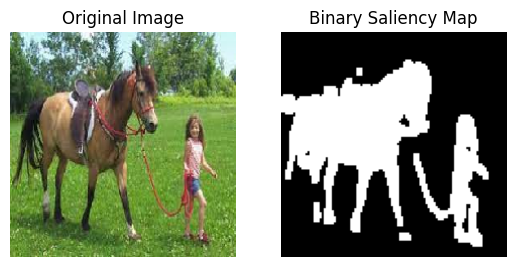

In [107]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\horse and girl.jpeg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.15
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 36ms/step


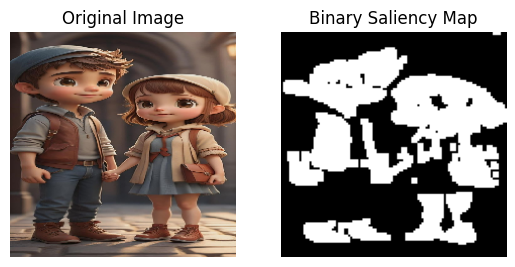

In [108]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Boy_girl.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.2
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 41ms/step


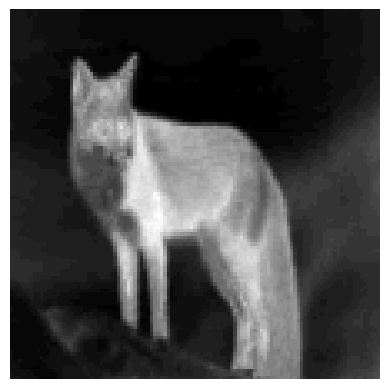

In [109]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Fox.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 37ms/step


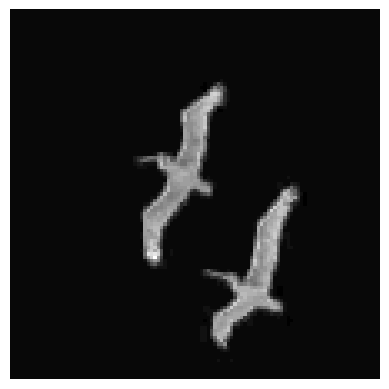

In [110]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000473.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 55ms/step


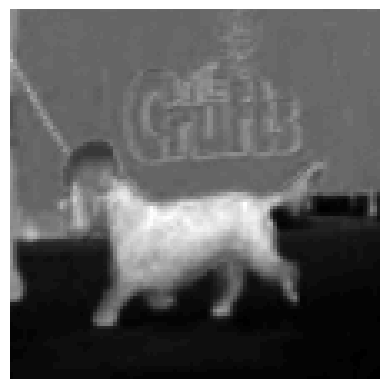

In [111]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000003.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 42ms/step


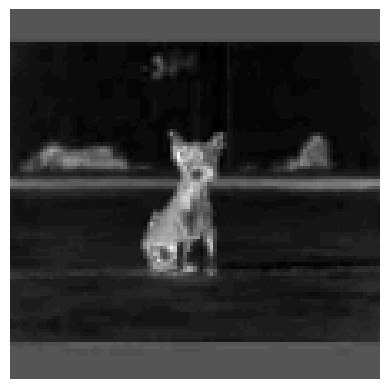

In [112]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000661.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 37ms/step


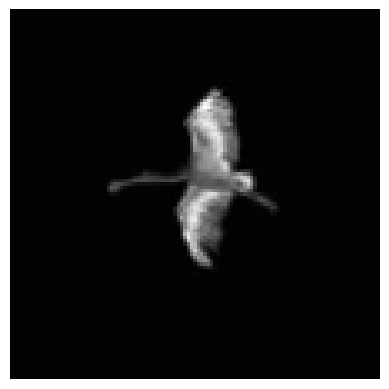

In [113]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000652.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 37ms/step


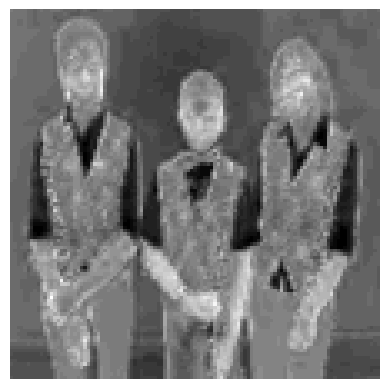

In [114]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00072735.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 71ms/step


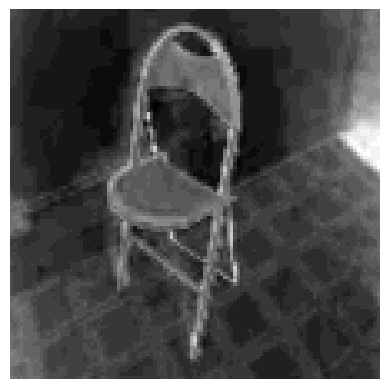

In [115]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000998.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 51ms/step


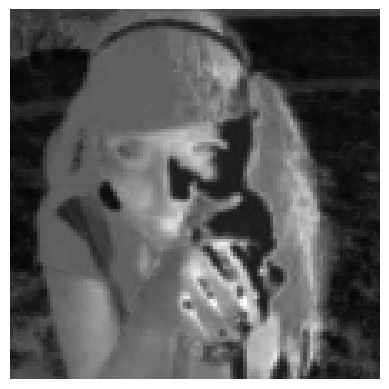

In [116]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00001360.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 63ms/step


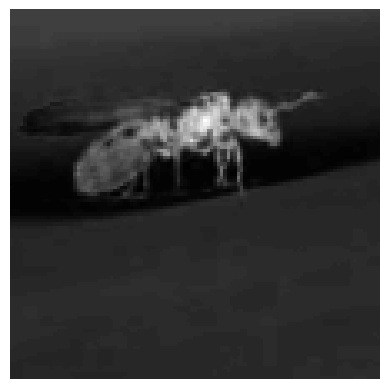

In [117]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00000196.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 36ms/step


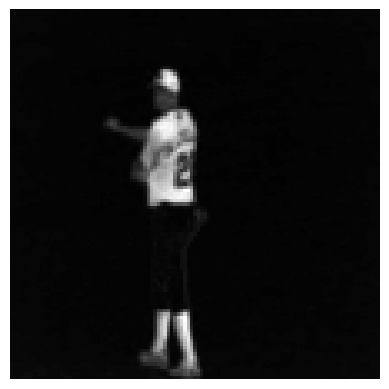

In [118]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUTS-TE\DUTS-TE\DUTS-TE-Image\ILSVRC2012_test_00018970.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 36ms/step


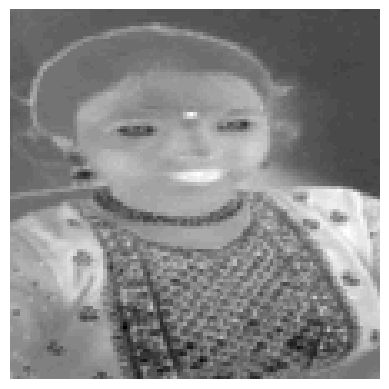

In [119]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Sahithi_purple_dress.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 51ms/step


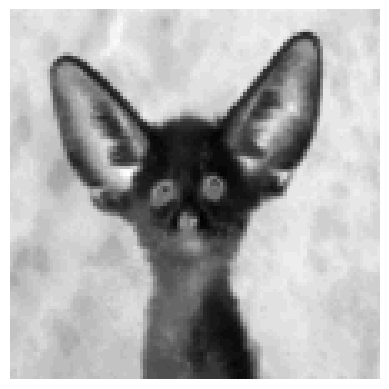

In [120]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\random animal.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 42ms/step


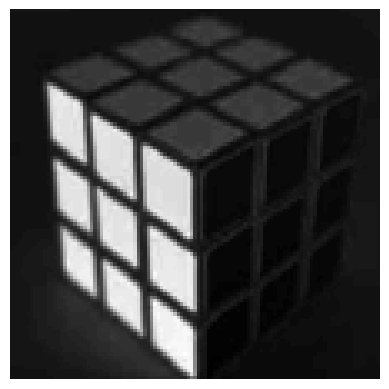

In [121]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\cube.jpeg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 42ms/step


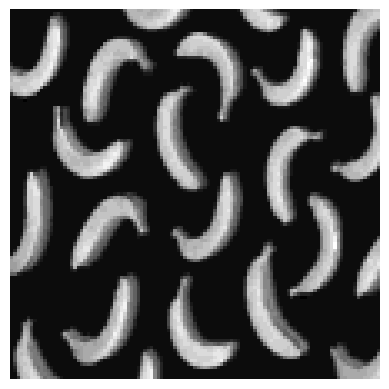

In [122]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\bananas.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 40ms/step


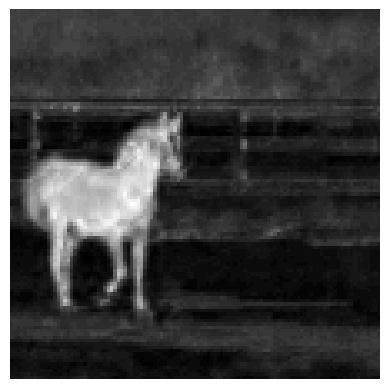

In [123]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\horse.jpeg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 37ms/step


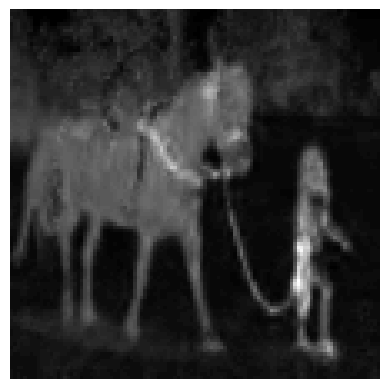

In [124]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\horse and girl.jpeg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

1/1 [==============================] - 0s 37ms/step


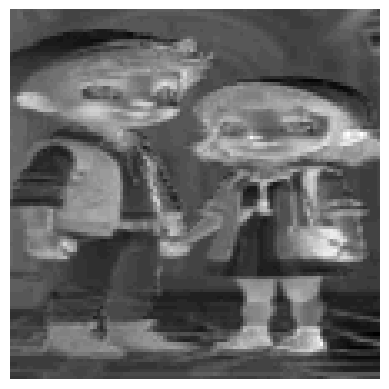

In [125]:
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Boy_girl.jpg")

input_image = np.expand_dims(input_image, axis=0)

prediction = cnn_model.predict([input_image, input_image])

prediction = prediction[0] * 255.0 

prediction = prediction.astype(np.uint8)

plt.imshow(prediction, cmap='gray')

plt.axis('off') 

plt.show()

In [126]:
save_model_weights(cnn_model, '60_32_0.01_DUT-OMRON_DUTS_after_60_epochs.h5')

cnn_model.save('60_32_0.01_DUT-OMRON_DUTS.h5')

1/1 [==============================] - 0s 58ms/step


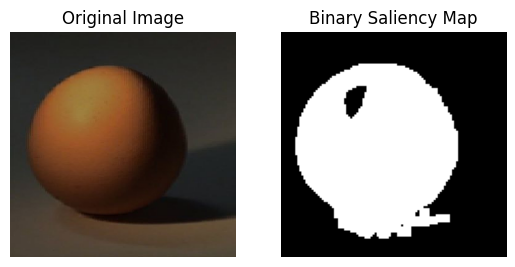

In [179]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Egg.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.185
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 40ms/step


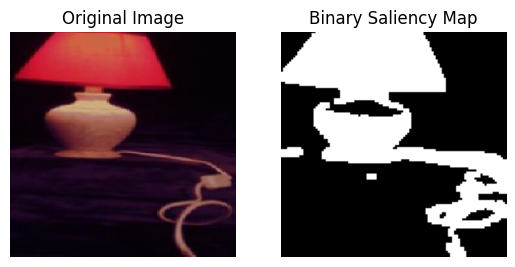

In [169]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\lamp.jpeg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.218
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 41ms/step


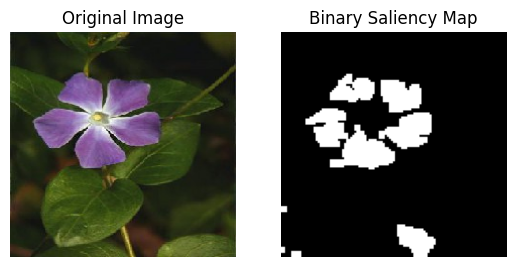

In [157]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\purple flower.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.193
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 35ms/step


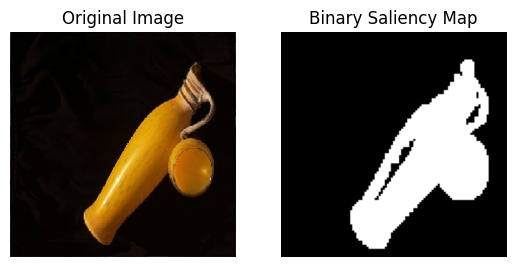

In [135]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\yellow vase.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.195
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

In [180]:
save_model_weights(cnn_model, '60_32_0.01_DUT-OMRON_DUTS_after_60_epochs.h5')

cnn_model.save('60_32_0.01_DUT-OMRON_DUTS.h5')